In [8]:
# Measurment Problem #1: Wide-bandwidth peak detection instability
# Problem: Capturing 2.4 MHz bandwidth with multiple FM stations results in
# unstable peak frequency measurments as different signals dominate at different times

import sqlite3
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# configuration
DB_PATH = '/Users/daejeon/workspace/project/Metal_SDR/data/captures/capture_manifest.db'

def analyze_capture(file_path, center_freq_hz):
    """Extract peak frequency from IQ capture"""
    iq_data = np.fromfile(file_path, dtype=np.complex64)
    fs = 2.4e6
    f, psd = signal.welch(iq_data, fs, nperseg=1024)

    peak_idx = np.argmax(psd)
    peak_freq_offset = f[peak_idx]
    actual_peak_freq = center_freq_hz + peak_freq_offset

    return actual_peak_freq, peak_freq_offset, f, psd

def validate_temporal_consistency(capture_ids=None):
    """
    Validate that captures at the same frequency produce consistent peak measjurments

    Wide-bandwith FM captures show 0.8 Mhz variations in peak frequency because different
    stations dominate at different times
    """
    conn = sqlite3.connect(DB_PATH)
    c = conn.cursor()

    if capture_ids:
        placeholders = ','.join('?' * len(capture_ids))
        c.execute(f'SELECT id, center_freq_hz, file_path, timestamp FROM captures WHERE id IN ({placeholders})', capture_ids)
    else:
        c.execute('SELECT id, center_freq_hz, file_path, timestamp FROM captures ORDER BY id')

    captures = c.fetchall()
    conn.close()

    results = []
    for cap_id, center_freq, file_path, timestamp in captures:
        peak_freq, offset, f, psd = analyze_capture(file_path, center_freq)
        results.append({
            'id': cap_id,
            'timestamp': timestamp,
            'center_freq_mhz': center_freq / 1e6,
            'peak_freq_mhz': peak_freq / 1e6,
            'offset_mhz': offset / 1e6
        })
        print(f"Capture {cap_id} ({timestamp}): Peak at {peak_freq/1e6:.3f} MHz (offset: {offset/1e6:+.3f} MHz)")

        # calculate variation
        if len(results) > 1:
            peak_freqs = [r['peak_freq_mhz'] for r in results]
            variation = max(peak_freqs) - min(peak_freqs)
            print(f"\nPeak frequency variation: {variation:.3f} MHz")
            print(f"Standard deviation: {np.std(peak_freqs):.3f} MHz")

            if variation > 0.1:
                print(f"\n⚠️  MEASUREMENT PROBLEM DETECTED:")
                print(f"   Wide-bandwidth captures show {variation:.3f} MHz drift")
                print(f"   Different signals dominate at different times")
                print(f"   Solution: Use narrower bandwidth or track multiple peaks")

        return results

def plot_psd_comparison(capture_ids):
    """Plot PSDs from multiple captures to visualize signal variation"""
    conn = sqlite3.connect(DB_PATH)
    c = conn.cursor()

    fig, axes = plt.subplots(len(capture_ids), 1, figsize=(12, 4*len(capture_ids)))
    if len(capture_ids) == 1:
        axes = [axes]

    for idx, cap_id in enumerate(capture_ids):
        c.execute('SELECT center_freq_hz, file_path, timestamp FROM captures WHERE id = ?', (cap_id,))
        center_freq, file_path, timestamp = c.fetchone()

        _, _, f, psd = analyze_capture(file_path, center_freq)

        axes[idx].semilogy(f/1e6, psd)
        axes[idx].set_xlabel('Frequency Offset (Mhz)')
        axes[idx].set_ylabel('PSD')
        axes[idx].set_title(f'Capture {cap_id}: {timestamp}')
        axes[idx].grid(True)

    conn.close()
    plt.tight_layout()
    plt.show()

# Usage:
# results = validate_temporal_consistency()  # All captures
# results = validate_temporal_consistency([1, 2, 3])  # Specific captures
# plot_psd_comparison([1, 2, 3])  # Visual comparison

In [9]:
conn = sqlite3.connect(DB_PATH)
c = conn.cursor()

# Delete captures with Windows paths
c.execute("DELETE FROM captures WHERE file_path LIKE 'D:%'")
print(f"Deleted {c.rowcount} old Windows captures")

conn.commit()
conn.close()

Deleted 1 old Windows captures


In [10]:
results = validate_temporal_consistency()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/daejeon/workspace/project/Metal_SDR/data/captures/capture_20251006_180309_100Mhz.sigmf-data'

In [11]:
conn = sqlite3.connect(DB_PATH)
c = conn.cursor()
c.execute("DELETE FROM captures WHERE id = 2")
print(f"Deleted {c.rowcount} missing capture(s)")
conn.commit()
conn.close()

Deleted 1 missing capture(s)


In [12]:
results = validate_temporal_consistency([3, 4, 5, 6, 7, 8, 9])

Capture 3 (2025-10-06T18:49:16.877041): Peak at 105.905 MHz (offset: +0.005 MHz)


In [13]:
results = validate_temporal_consistency()

Capture 3 (2025-10-06T18:49:16.877041): Peak at 105.905 MHz (offset: +0.005 MHz)


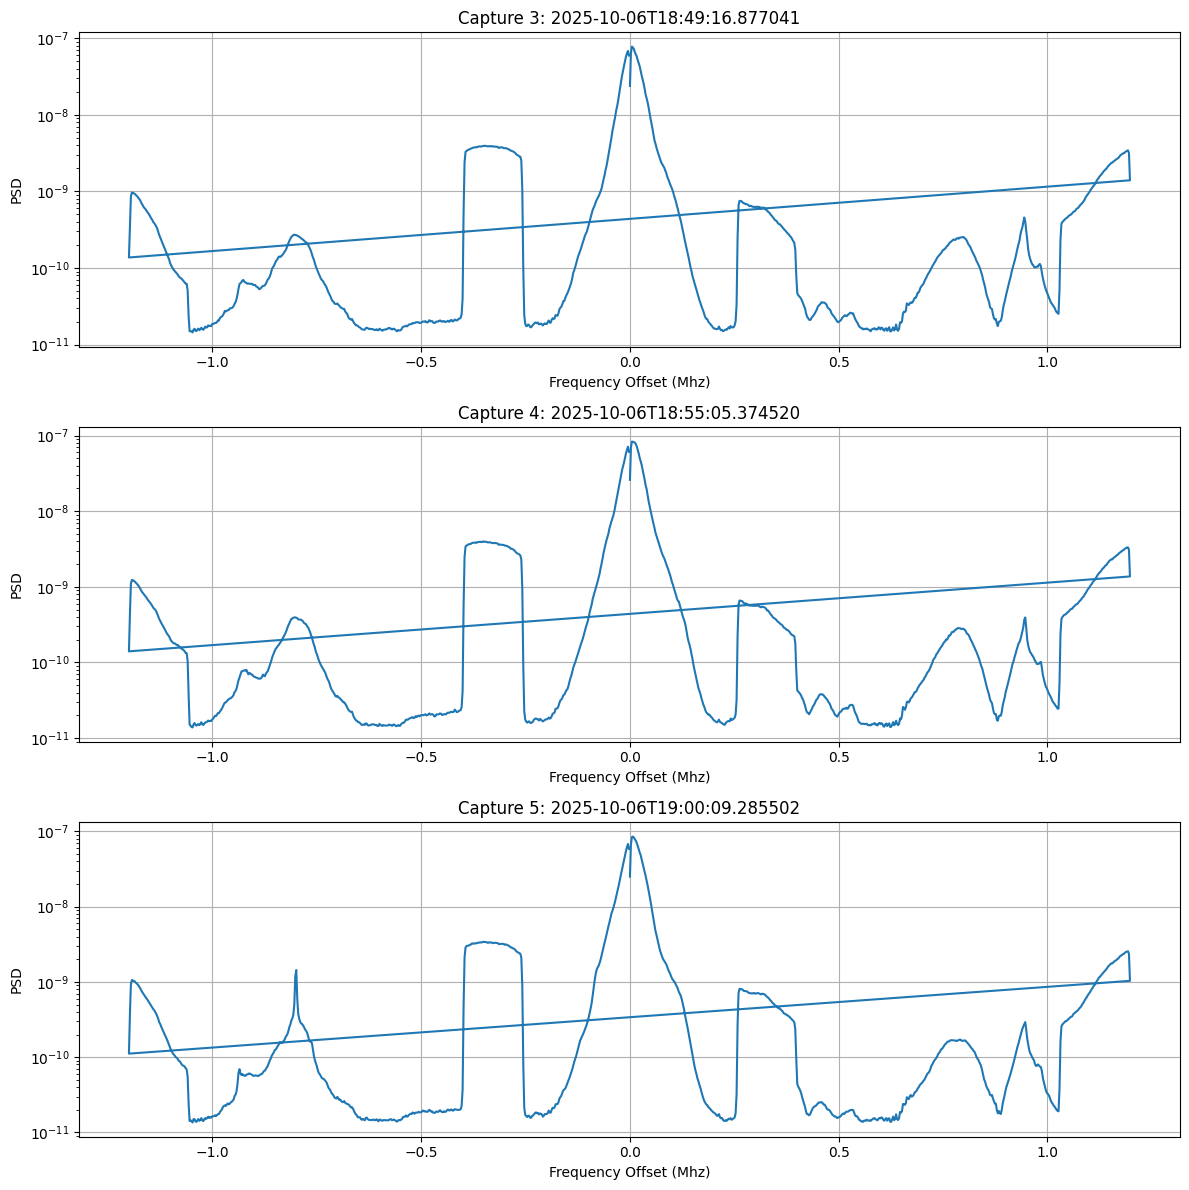

In [14]:
plot_psd_comparison([3, 4, 5])

In [15]:
validate_temporal_consistency([3, 4, 5])

Capture 3 (2025-10-06T18:49:16.877041): Peak at 105.905 MHz (offset: +0.005 MHz)


[{'id': 3,
  'timestamp': '2025-10-06T18:49:16.877041',
  'center_freq_mhz': 105.9,
  'peak_freq_mhz': np.float64(105.9046875),
  'offset_mhz': np.float64(0.0046875)}]

In [16]:
results = validate_temporal_consistency([3, 4, 5])
print(f"Number of captures analyzed: {len(results)}")
for r in results:
    print(f"Capture {r['id']}: {r['peak_freq_mhz']:.3f} MHz")

Capture 3 (2025-10-06T18:49:16.877041): Peak at 105.905 MHz (offset: +0.005 MHz)
Number of captures analyzed: 1
Capture 3: 105.905 MHz


In [17]:
validate_temporal_consistency([4])

Capture 4 (2025-10-06T18:55:05.374520): Peak at 105.905 MHz (offset: +0.005 MHz)


[{'id': 4,
  'timestamp': '2025-10-06T18:55:05.374520',
  'center_freq_mhz': 105.9,
  'peak_freq_mhz': np.float64(105.9046875),
  'offset_mhz': np.float64(0.0046875)}]

In [18]:
validate_temporal_consistency([5])

Capture 5 (2025-10-06T19:00:09.285502): Peak at 105.907 MHz (offset: +0.007 MHz)


[{'id': 5,
  'timestamp': '2025-10-06T19:00:09.285502',
  'center_freq_mhz': 105.9,
  'peak_freq_mhz': np.float64(105.90703125),
  'offset_mhz': np.float64(0.00703125)}]